In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os
import shutil
from sklearn.model_selection import train_test_split

2024-11-20 23:21:30.390688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732166490.402413    4539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732166490.405817    4539 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 23:21:30.417119: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set Image directories
dataset_dir = '../dataset/images'
train_dir = '../dataset/train'
validation_dir = '../dataset/val'
test_dir = '../dataset/test'

In [ ]:
# Data generator functions (creates our dataset)
def create_datagen(preprocessing_function =""):
    return ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rescale=1./255  # Normalize pixel values
    )
def create_generator(datagen, directory, shuffle):
    return datagen.flow_from_directory(
        directory,
        target_size=(300,300),
        batch_size=16,
        class_mode='categorical',
        shuffle=shuffle,
    )

In [ ]:
# Create data generators (datasets for validation, testing, and training)
datagen_cnn = create_datagen(tf.keras.applications.vgg16.preprocess_input)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator_cnn = create_generator(datagen_cnn, train_dir, True)
val_generator = create_generator(val_datagen, validation_dir, True)
test_generator = create_generator(test_datagen, test_dir, False)

Found 14357 images belonging to 120 classes.
Found 3082 images belonging to 120 classes.
Found 3141 images belonging to 120 classes.


In [ ]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))

# 1st Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# 2nd Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))

# 3rd Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu'))

# 4th Max Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten Layer
model.add(Flatten())

# Fully Connected (Dense) Layer
model.add(Dense(512, activation='relu'))

# Output Layer (categorical classification (120 predicatable outputs))
model.add(Dense(120, activation='softmax'))


In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 33, 33, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        61,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,004,920 (129.72 MB)

 Trainable params: 34,004,920 (129.72 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Model Training
history = model.fit(train_generator_cnn, validation_data=val_generator, epochs=5)

Epoch 1/5
 51/898 ━━━━━━━━━━━━━━━━━━━━ 2:13 157ms/step - accuracy: 0.0080 - loss: 4.8175

2024-11-20 23:23:43.654699: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,32,298,298]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,3,300,300]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-20 23:23:43.734108: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,149,149]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.0139 - loss: 4.7510

2024-11-20 23:25:15.270138: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,32,298,298]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,300,300]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-20 23:25:15.320746: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,149,149]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

898/898 ━━━━━━━━━━━━━━━━━━━━ 123s 137ms/step - accuracy: 0.0139 - loss: 4.7509 - val_accuracy: 0.0127 - val_loss: 5.5600
Epoch 2/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 119s 133ms/step - accuracy: 0.0474 - loss: 4.3173 - val_accuracy: 0.0114 - val_loss: 6.0335
Epoch 3/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 120s 134ms/step - accuracy: 0.0993 - loss: 4.0110 - val_accuracy: 0.0169 - val_loss: 6.1487
Epoch 4/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 117s 130ms/step - accuracy: 0.2053 - loss: 3.3739 - val_accuracy: 0.0143 - val_loss: 7.0939
Epoch 5/5
898/898 ━━━━━━━━━━━━━━━━━━━━ 119s 132ms/step - accuracy: 0.4480 - loss: 2.2326 - val_accuracy: 0.0169 - val_loss: 8.1127


In [20]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.classes.size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Reset the test generator
test_generator.reset()

# Get the predictions
predictions = model.predict(test_generator, steps=test_generator.classes.size)

# Get true labels
y_true = test_generator.classes

# Convert predicted probabilities to class labels
y_pred = predictions.argmax(axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, zero_division=1))

3141/3141 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.0169 - loss: 8.0790   
Test Loss: 8.082167625427246
Test Accuracy: 0.015600127167999744


2024-11-20 23:40:32.105181: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 16845769055107995867


3141/3141 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step   
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        23
           1       1.00      0.00      0.00        28
           2       0.02      0.63      0.03        38
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00        33
           5       1.00      0.00      0.00        29
           6       1.00      0.00      0.00        30
           7       1.00      0.00      0.00        26
           8       1.00      0.00      0.00        26
           9       0.00      0.00      0.00        36
          10       0.00      0.00      0.00        27
          11       1.00      0.00      0.00        30
          12       1.00      0.00      0.00        29
          13       1.00      0.00      0.00        26
          14       1.00      0.00      0.00        24
          15       1.00      0.00      0.00        23
          1

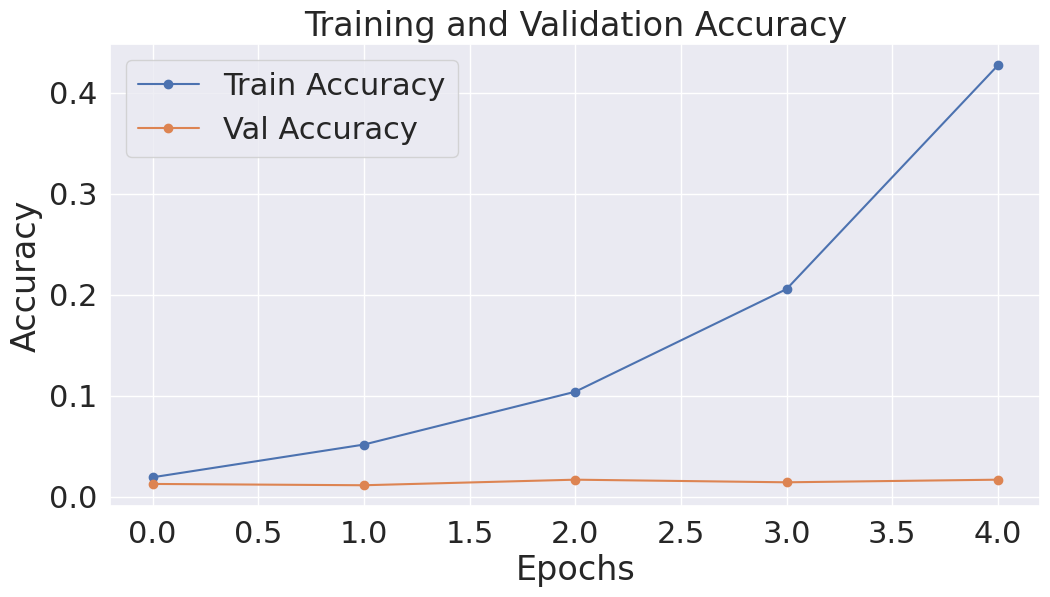

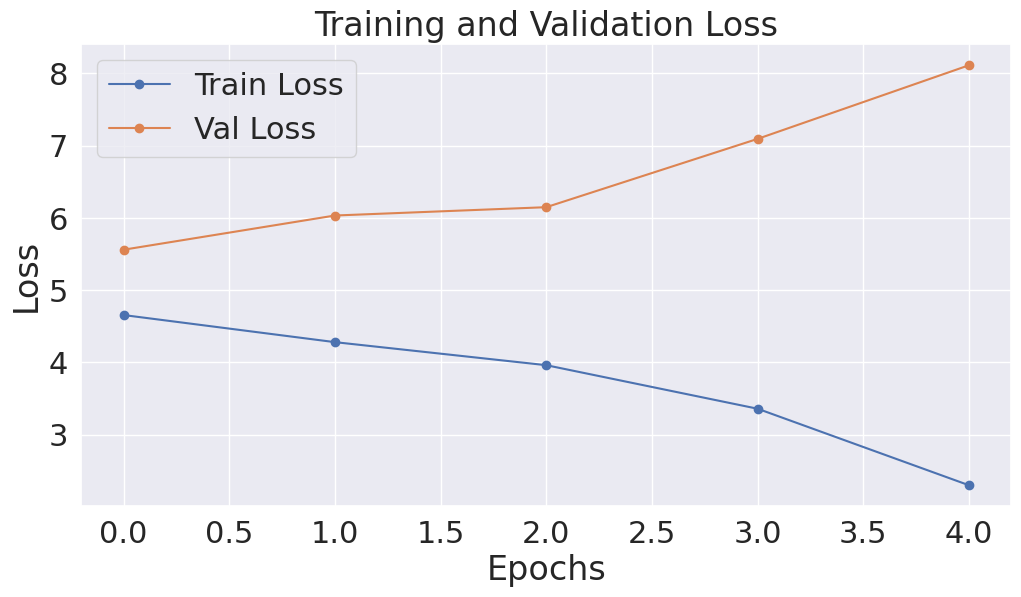

In [16]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()